In [2]:
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage import morphology
from skimage.segmentation import slic
from skimage.util import img_as_float

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import sys
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


In [3]:
# needs a good tidying

class Lesion:
    # compactness, symmetry, colour
    def __init__(self, ID, im, seg, lesiontype=None):
        assert lesiontype in [0,1,2,None] # 0: healthy, 1: keratosis, 2: melanoma, None: unknown
        self.lesiontype = lesiontype 
        self.ID = ID
        self.im = im
        self.seg = seg
        
        # a,b = np.where(seg == 1)
        a,b = np.asarray(seg == 1).nonzero()

        self.bottom, self.top, self.leftmost, self.rightmost = max(a), min(a), min(b), max(b)
        self.center = (  (self.top+self.bottom) // 2  ,  (self.leftmost + self.rightmost) // 2  )
        # note the center is from the original, and not the cropped image
        
        margin = 50
        self.croppedSeg = self.seg[self.top-margin:self.bottom+margin, self.leftmost-margin:self.rightmost+margin]
        #im_part = im[60:120,130:220,:]
        
        self.area = np.sum(seg)

        self.perimeter = self.findPerimeter()

        # perimeter**2 / ( 4*pi*area )    // compactness
        self.compactness = (self.perimeter**2) / (4*np.pi*self.area)

        self.rgb = self.getRGBVectors()
        self.calcRGBStats() # self.lesionColorStats is now accessible (dictionary)
        
    def plotRGBScatter(self):
        fig = plt.figure()
        axis = fig.add_subplot(1,1,1, projection ='3d')

        r,g,b = list(self.RGB[0]), list(self.RGB[1]), list(self.RGB[2])

        axis.scatter(r,g,b, c='#ff0000', marker='o', alpha=0.05)
        axis.set_xlabel('Red')
        axis.set_ylabel('Green')
        axis.set_zlabel('Blue')
        plt.show()
    def getRGBVectors(self):
        x,y = np.where(self.seg == 1)
        rgb = im[x,y,:].transpose()
        # rgb[0] = r, rgb[1] = g, rgb[2] = b
        return rgb
    def calcRGBStats(self):
        segmask = (self.seg > 0)
        image = img_as_float(self.im)
        # using superpixels doesn't add anything to the analysis, as the RGB averages calculated on the superpixels yield the same as RGB averages across the entire lesion... 
        segments = slic(image, compactness=6.0, mask=segmask, n_segments=50, sigma = 5, enforce_connectivity=True, multichannel=True,convert2lab=True)
        
#         print(len(segments[segmask])) # these correspond to the same pixels as rgb
#         print(len(rgb[0])) # these correspond to the same pixels as segments
        segmentCount = len(np.unique(segments[segmask]))
        rs = [[] for i in range(segmentCount)]
        gs = [[] for i in range(segmentCount)]
        bs = [[] for i in range(segmentCount)]
        for i, seg in enumerate(segments[segmask]):
            # holy cow... 
            try:
                rs[seg-1].append( self.rgb[0][i] ) # appends the r value of pixel i to it's segments list of r values in rs
                gs[seg-1].append( self.rgb[1][i] )
                bs[seg-1].append( self.rgb[2][i] )
            except Exception as e:
                print("!!! getRGBStats(), ID:",self.ID," some stuff went wrong, (i,seg): (", i,",",seg,")")
                print(e)
                break # would use exit(), but no worko in notebook
        # calculate average of each segment... 
        segmentAvgs = [[] for i in range(segmentCount)] # each list contains [avgRed, avgGreen, avgBlue]. index corresponds to segment.
#         print("---------")
        for i in range(segmentCount):
            segmentAvgs[i].append( np.asarray(rs[i]).mean() )
            segmentAvgs[i].append( np.asarray(gs[i]).mean() )
            segmentAvgs[i].append( np.asarray(bs[i]).mean() )
#         print(len(segmentAvgs))
        # for i in segmentAvgs: print(i)

        # okay, make segmentAvgs into a 2D ndarray, and then transpose it so there's 3 vectors of averages, then you can do statistics on 'em
        segAvgMat = np.asarray(segmentAvgs).transpose()
        # the stats on the averages are the same as the averages across the whole lesion, thus the superpixels (SLIC) doesn't add anything, but if one wanted to print a picture of the superpixels with the average color, then this matrix should be used. 
        
        self.SLICSegs = segments # for (perhaps) later use
        self.SLICSegRGBAverages = segAvgMat # for (perhaps) later use
        
        self.lesionColorStats = {"mean_red":segAvgMat[0].mean(), 
                                 "mean_green":segAvgMat[1].mean(), 
                                 "mean_blue":segAvgMat[2].mean(),
                                 "std_red":np.std(segAvgMat[0]),
                                 "std_green":np.std(segAvgMat[1]),
                                 "std_blue":np.std(segAvgMat[2])
                            }
        
    def printlocation(self):
        print("top:", self.top, "bottom:", self.bottom, "leftmost:", self.leftmost, "rightmost:", self.rightmost)
        
    def showCropSeg(self):
        plt.imshow(self.croppedSeg, cmap="gray")

    def findPerimeter(self, show=False):
        struct_el = morphology.disk(20)
        seg_eroded = morphology.binary_erosion(self.seg, struct_el)
        self.perimeterimg = self.seg - seg_eroded
        if show:
            self.compareSeg(self.perimeterimg)
        
        self.perimeter = np.sum(self.perimeterimg)
        return self.perimeter
    
    def compareSeg(self, im):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
        axes[0].imshow(self.seg, cmap='gray')
        axes[1].imshow(im, cmap='gray')
        fig.tight_layout()
        
    
    def edgeFlatCornerTexture(self, showgreyscale=False):
        radius = 3
        n_points = 8 * radius # Number of circularly symmetric neighbour set points
        METHOD = 'uniform'
        segmask = (self.seg[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1] > 0)
        grayscale = rgb2gray(self.im[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1])
        image = grayscale
        if showgreyscale:
            plt.imshow(grayscale)
        lbp = local_binary_pattern(image, n_points, radius, METHOD)
#         print(image.shape)
#         print(lbp.shape)
#         print("lbp.ravel()")
#         print(len(lbp[segmask].ravel()))
#         print("np hist")
        n_bins = int(lbp[segmask].max() + 1)
        hist_vals = np.histogram(lbp[segmask].ravel(), density=True, bins=n_bins, range=(0, n_bins))[0]
#         print(hist_vals)
        flatreg = np.concatenate((hist_vals[0:4],hist_vals[21:26])).sum()
        #flatreg = flatreg.sum()
        cornerreg = np.concatenate((hist_vals[4:9],hist_vals[15:20])).sum()
        #cornerreg = cornerreg.sum()
        edgereg = hist_vals[9:14].sum()
        #edgereg = edgereg.sum()
        
        return (flatreg, cornerreg, edgereg) # doesn't sum to 1 cuz not all bins are included...
        

In [4]:
im = plt.imread('data/example_image/ISIC_0001769.jpg')
seg=plt.imread('data/example_segmentation/ISIC_0001769_segmentation.png')
les1 = Lesion("0001769", im, seg)

{'mean_red': 163.45496269707712,
 'mean_green': 101.54852679160291,
 'mean_blue': 70.08135787937066,
 'std_red': 10.9111778419778,
 'std_green': 17.46885903146363,
 'std_blue': 18.01914541633402}

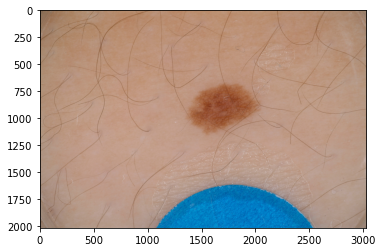

In [5]:
plt.imshow(im)
les1.lesionColorStats

(0.468319763138416, 0.22737786824574388, 0.24593819393042193)

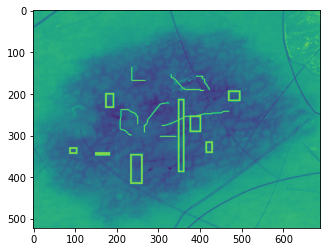

In [20]:
im1 = plt.imread('data/example_image/1test.jpg')
les2 = Lesion("1test", im1, seg)
les2.edgeFlatCornerTexture(True)

(0.6849457010734239, 0.1446900043941328, 0.12681132430792408)

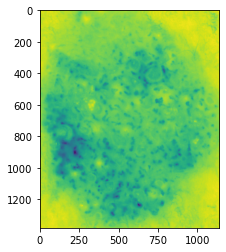

In [22]:
im2 = plt.imread("data/example_image/ISIC_0012383.jpg")
seg2 = plt.imread("data/example_segmentation/ISIC_0012383_segmentation.png")
les3 = Lesion("ISIC_0012383", im2, seg2)
les3.edgeFlatCornerTexture(True)